In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


In [ ]:
########################################
df = pd.read_csv("/content/drive/MyDrive/vshe/transactions.csv")

In [ ]:
########################################
df.head(-5)

,ID,TrDateNew,ClientId,StoreID,ProductID,SubgroupID,GroupID,PaymentID,CCount,AmountWoDiscont,Amount,MagrinGross,Month,Client_return
0,0,2020-01-31,1,1,1,1,1,1,1.0,57,57,17.50,1,1
1,1,2020-01-31,1,1,2,1,1,1,1.0,49,49,15.24,1,1
2,2,2020-01-31,1,1,3,1,1,1,2.0,100,100,18.52,1,1
3,3,2020-01-31,1,1,4,1,1,1,1.0,38,38,13.67,1,1
4,4,2020-01-31,1,1,5,1,1,1,1.0,86,86,39.40,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340922,340922,2020-05-20,32492,1,5072,65,20,70393,2.0,627,627,296.05,5,-1
340923,340923,2020-05-20,32492,1,7005,65,20,70393,2.0,706,706,274.56,5,-1
340924,340924,2020-05-20,32492,1,11181,65,20,70393,1.0,260,260,126.67,5,-1
340925,340925,2020-05-20,32492,1,23173,65,20,70393,1.0,203,203,92.49,5,-1


In [ ]:
########################################
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340932 entries, 0 to 340931
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ID               340932 non-null  int64         
 1   TrDateNew        340932 non-null  datetime64[ns]
 2   ClientId         340932 non-null  int64         
 3   StoreID          340932 non-null  int64         
 4   ProductID        340932 non-null  int64         
 5   SubgroupID       340932 non-null  int64         
 6   GroupID          340932 non-null  int64         
 7   PaymentID        340932 non-null  int64         
 8   CCount           340932 non-null  float64       
 9   AmountWoDiscont  340932 non-null  int64         
 10  Amount           340932 non-null  int64         
 11  MagrinGross      340932 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(9)
memory usage: 31.2 MB


In [ ]:
########################################
df['TrDateNew'] = pd.to_datetime(df['TrDateNew'])

In [ ]:
########################################
df['Month'] = df['TrDateNew'].dt.month

In [ ]:
########################################
return_client = [0] * 294039
return_client[0] = 1

temp_znach = 1

for i in tqdm(range(1, 294039)):
  if df['ClientId'][i] == df['ClientId'][i - 1]:
    return_client[i] = temp_znach
  else:
    temp_month = df['Month'][i]
    if df['ClientId'][i] in set(df[df['Month'] == temp_month + 1]['ClientId']):
      temp_znach = 1
      return_client[i] = temp_znach
    else:
      temp_znach = 0
      return_client[i] = temp_znach

100%|██████████| 294038/294038 [13:40<00:00, 358.55it/s]


In [ ]:
########################################
return_client = return_client + [-1] * (340932 - len(return_client))

In [ ]:
########################################
df['Client_return'] = return_client

In [ ]:
########################################
df.to_csv('tran_new.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/vshe/tran_new.csv')

In [ ]:
trans_per_month = list(df.groupby(['ClientId', 'Month'])['ID'].count())
magrin_per_month = list(df.groupby(['ClientId', 'Month'])['MagrinGross'].sum())
sum_count = list(df.groupby(['ClientId', 'Month'])['CCount'].sum())
target = list(df.groupby(['ClientId', 'Month'])['Client_return'].mean())
max_count = list(df.iloc[df.groupby(["ClientId", "Month"])["MagrinGross"].idxmax().values]['CCount'])
mg_group = list(df.iloc[df.groupby(["ClientId", "Month"])["MagrinGross"].idxmax().values]['GroupID'])
mg_subgroup = list(df.iloc[df.groupby(["ClientId", "Month"])["MagrinGross"].idxmax().values]['SubgroupID'])
mp_group = list(df.iloc[df.groupby(["ClientId", "Month"])["CCount"].idxmax().values]['GroupID'])
mp_subgroup = list(df.iloc[df.groupby(["ClientId", "Month"])["CCount"].idxmax().values]['SubgroupID'])

In [ ]:
train_df = pd.DataFrame({'tpm': trans_per_month, 
                         'mpm': magrin_per_month, 
                         'sc': sum_count,
                         'mc': max_count,
                         'mgg': mg_group,
                         'mgsg': mg_subgroup,
                         'mpg': mp_group,
                         'mpsg': mp_subgroup,
                         'target' : target})

In [ ]:
train_df.head(10)

,tpm,mpm,sc,mc,mgg,mgsg,mpg,mpsg,target
0,18,2086.42,32.0,2.0,3,3,11,21,1.0
1,50,2107.42,84.0,3.0,3,3,3,128,1.0
2,7,370.04,12.0,2.0,3,64,13,46,1.0
3,7,522.46,16.0,1.0,10,191,13,109,1.0
4,2,161.46,2.0,1.0,3,64,3,64,-1.0
5,10,1903.83,13.0,1.0,7,10,5,6,1.0
6,6,587.91,10.0,1.0,5,171,13,46,1.0
7,3,541.48,3.0,1.0,19,51,9,354,1.0
8,9,652.59,10.0,1.0,6,164,20,183,0.0
9,1,232.43,3.0,3.0,8,12,8,12,1.0


In [ ]:
train_df.corr()

,tpm,mpm,sc,mc,mgg,mgsg,mpg,mpsg,target
tpm,1.000000,0.586716,0.754235,0.096401,-0.000435,-0.038014,-0.073906,-0.131141,0.164003
mpm,0.586716,1.000000,0.686121,0.208515,0.032800,0.051623,0.000923,0.009108,0.065650
sc,0.754235,0.686121,1.000000,0.487469,0.008766,-0.035228,-0.067544,-0.074006,0.123785
mc,0.096401,0.208515,0.487469,1.000000,-0.007832,-0.051140,-0.008386,0.003353,0.031926
mgg,-0.000435,0.032800,0.008766,-0.007832,1.000000,0.283655,0.592537,0.218229,-0.035901
mgsg,-0.038014,0.051623,-0.035228,-0.051140,0.283655,1.000000,0.198871,0.523847,-0.050080
mpg,-0.073906,0.000923,-0.067544,-0.008386,0.592537,0.198871,1.000000,0.402679,-0.070435
mpsg,-0.131141,0.009108,-0.074006,0.003353,0.218229,0.523847,0.402679,1.000000,-0.083858
target,0.164003,0.065650,0.123785,0.031926,-0.035901,-0.050080,-0.070435,-0.083858,1.000000


In [ ]:
train_df = train_df.drop(['sc'], axis = 1)

In [ ]:
train_df = train_df[train_df['target'] != -1]

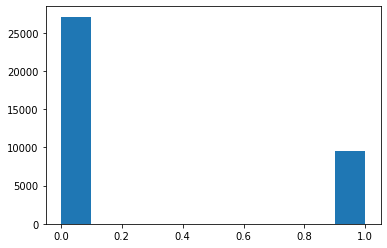

In [ ]:
plt.hist(train_df['target'])
plt.show()

In [ ]:
df_for_train, df_for_test = train_test_split(train_df,
                                             test_size=0.2,
                                             shuffle = True,
                                             random_state=42)

In [ ]:
test_X = df_for_test.drop(['target'], axis = 1)
test_y = df_for_test['target']

In [ ]:
X_df = df_for_train.drop(['target'], axis = 1)
y_df = df_for_train['target']

In [ ]:
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_df, y_df)

In [ ]:
#!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
model = CatBoostClassifier(cat_features = ['mgg', 'mgsg', 'mpg', 'mpsg'])

In [ ]:
model.fit(X_res, y_res, verbose = 100)

Learning rate set to 0.051624
0:	learn: 0.6660032	total: 86.5ms	remaining: 1m 26s
100:	learn: 0.4058457	total: 5.29s	remaining: 47.1s
200:	learn: 0.3953274	total: 13.1s	remaining: 51.9s
300:	learn: 0.3843893	total: 19.4s	remaining: 45s
400:	learn: 0.3786211	total: 24.6s	remaining: 36.7s
500:	learn: 0.3732306	total: 30s	remaining: 29.9s
600:	learn: 0.3685040	total: 35.3s	remaining: 23.4s
700:	learn: 0.3644706	total: 40.8s	remaining: 17.4s
800:	learn: 0.3606995	total: 45.9s	remaining: 11.4s
900:	learn: 0.3570203	total: 51.3s	remaining: 5.63s
999:	learn: 0.3532752	total: 56.7s	remaining: 0us


In [ ]:
print('test ', roc_auc_score(test_y, model.predict_proba(test_X)[:, 1]) * 2 - 1)

test  0.28919776652724716


In [ ]:
rf_model = RandomForestClassifier(max_depth = 9, criterion = 'gini')
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=9)

In [ ]:
print('train ', roc_auc_score(y_train, rf_model.predict_proba(X_train)[:, 1]) * 2 - 1)
print('test ', roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]) * 2 - 1)

train  0.49990469494593137
test  0.3061796406541164
